In [3]:
import h5py
import os
import argparse
import glob
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tabulate import tabulate
import json
import glob

In [33]:
# PRED_PATH = r"C:\minowa\BloodPressureEstimation\repos\BBDM\results\ppg2abp\BrownianBridge\sample_to_eval\200\result.npy"
# PRED_PATH = r"C:\minowa\BloodPressureEstimation\repos\BBDM\results\ppg2abp3\BrownianBridge\sample_to_eval\200\result.npy"
# PRED_PATH=r'../repos/latent-diffusion/models/ldm/v4_ppg2abp-kl-f4/samples/00541968/2024-10-29-11-22-29/numpy'
PRED_PATH=r'C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv\configs\samples\00060880\2024-12-02-14-12-00\numpy'
PRED_PATH=r'C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv\configs\samples\00060880\2024-12-23-19-47-06\numpy'
PRED_PATH=r'C:\minowa\BloodPressureEstimation\repos\latent-diffusion\models\ldm\v3_ppg2abp-ldm-kl-4_2\samples\00064520\2024-12-23-19-32-07\numpy'
PRED_PATH=r'C:\minowa\BloodPressureEstimation\repos\latent-diffusion\models\ldm\v4_ppg2abp-kl-f4\samples\00077424\2024-10-15-13-06-52\numpy'
PRED_PATH=r'C:\minowa\BloodPressureEstimation\repos\latent-diffusion\models\ldm\v4_ppg2abp-kl-f4\samples\00077424\2024-12-23-22-24-54\numpy'
# PRED_PATH=r'C:\minowa\BloodPressureEstimation\repos\latent-diffusion\models\ldm\ldm_1d\samples\00112488\2024-12-24-12-46-37\numpy'
# PRED_PATH = r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\models\ldm\2024-10-26T13-18-05_v4_ppg2abp-ldm-kl-4-concat\samples\00135492\2024-12-23-21-50-56\numpy"
PRED_PATH=r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\models\ldm\v3_ppg2abp-kl-f4\samples\00722624\2024-12-24-13-22-09\numpy"

In [106]:
file = np.load(PRED_PATH)
file.shape

PermissionError: [Errno 13] Permission denied: 'C:\\minowa\\BloodPressureEstimation\\repos\\latent-diffusion\\models\\ldm\\v3_ppg2abp-ldm-kl-4_2\\samples\\00064520\\2024-12-23-19-32-07\\numpy'

In [4]:
gt = file[0]
out = file[1]

NameError: name 'file' is not defined

In [34]:
out = []
gt = []
files = glob.glob(PRED_PATH+"/*.npz")
for file in files:
    a = np.load(file)
    _out = a['arr_0'].squeeze()
    _gt = a['arr_1'].squeeze()
    out.append(_out)
    gt.append(_gt)
out = np.concatenate(out)
gt = np.concatenate(gt)

121

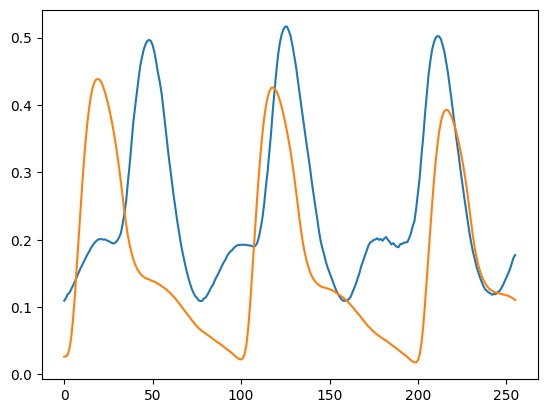

In [18]:
i = np.random.randint(128)
plt.plot(out[i])
plt.plot(gt[i])
i

In [19]:
out.shape

(9984, 256)

In [35]:

def calc_min_max(x):
    # x = (x.astype(np.float32)/127.5-1)
    return np.nanmin(x,axis=1),np.nanmax(x,axis=1)

In [36]:
scales = np.load(r"../data\processed\BP_npy\0625_256_2_clean\p00\scale_train.npy")
# scales = np.load(r"../data\processed\BP_npy\1127_256_balanced\p00\scale_train.npy")

In [37]:
gt[:] -= scales[0,0]
gt[:] /= scales[0,1]
out[:] -= scales[0,0]
out[:] /= scales[0,1]

In [10]:
out -= 9

In [38]:
gt_min,gt_max = calc_min_max(gt)
out_min,out_max = calc_min_max(out)
errors = np.zeros((2,*out_min.shape))
errors[0,:]=out_min-gt_min
errors[1,:]=out_max-gt_max
gt_mean = np.mean(gt.flatten())
out_mean = np.mean(out.flatten())
gt_std = np.std(gt.mean(axis=1),dtype=np.float64)
out_std = np.std(out.mean(axis=1),dtype=np.float64)
n_samples = errors.shape[1]
me = np.mean(errors,axis=1)
mae = np.mean(np.abs(errors),axis=1)
rmse = np.sqrt(np.mean(errors**2,axis=1))
std = np.std(errors,axis=1)
print(me.shape,mae.shape,rmse.shape,std.shape)
error_5 = np.count_nonzero(np.abs(errors)<=5,axis=1)/n_samples*100
error_15 = np.count_nonzero(np.abs(errors)<=15,axis=1)/n_samples*100
error_10 = np.count_nonzero(np.abs(errors)<=10,axis=1)/n_samples*100

(2,) (2,) (2,) (2,)


In [39]:
print("""
          test data samples:
          # samples : {}
          
          Eval Stats:   DBP    SBP
          MAE:        {:6.3f} {:6.3f}
          RMSE:       {:6.3f} {:6.3f}
          Mean Error: {:6.3f} {:6.3f}
          STD:        {:6.3f} {:6.3f}
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
          SBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
           
          
          """.format(
            n_samples,
            *mae,
            *rmse,
            *me,
            *std,
            error_5[0], error_10[0], error_15[0],
            error_5[1], error_10[1], error_15[1],
          ))
print("## string for google spredsheet ##")
print(",".join(f"{x:.3f}" for x in[mae[0],rmse[0],me[0],std[0],mae[1],rmse[1],me[1],std[1]]))


          test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:        11.740 21.676
          RMSE:       14.895 26.972
          Mean Error:  0.073  0.721
          STD:        14.895 26.963
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      27.4%   51.0%   70.0%
          SBP      14.7%   28.5%   41.5%
           
          
          
## string for google spredsheet ##
11.740,14.895,0.073,14.895,21.676,26.972,0.721,26.963


```
-5 at train data as test
          test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:         8.511 16.779
          RMSE:       10.957 21.404
          Mean Error: -1.462 -0.940
          STD:        10.859 21.383
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      38.2%   66.1%   83.9%
          SBP      21.3%   39.4%   53.6%

          Eval Stats:   DBP    SBP
          MAE:         9.583 17.437
          RMSE:       12.636 22.193
          Mean Error: -6.462 -5.940
          STD:        10.859 21.383
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      36.6%   63.2%   78.2%
          SBP      19.7%   37.5%   53.1%
```
           
          
          

```
concat
test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:        10.620 16.856
          RMSE:       13.314 20.889
          Mean Error: -9.371 -9.094
          STD:         9.458 18.805
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      29.5%   54.4%   74.2%
          SBP      18.1%   36.2%   51.7% 
-9
test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:         7.477 15.070
          RMSE:        9.465 18.806
          Mean Error: -0.371 -0.094
          STD:         9.458 18.805
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      40.6%   72.6%   89.3%
          SBP      20.6%   39.7%   57.2%

last epoch 
          test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:        10.525 16.870
          RMSE:       13.292 20.967
          Mean Error: -9.188 -9.788
          STD:         9.606 18.542
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      28.8%   54.9%   76.5%
          SBP      18.3%   35.5%   51.0%
-9
test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:         7.445 14.724
          RMSE:        9.608 18.559
          Mean Error: -0.188 -0.788
          STD:         9.606 18.542
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      41.9%   74.0%   88.7%
          SBP      21.6%   41.6%   59.0%
        ```

BBDM_ balanced epoch1  
          test data samples:  
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:         9.478 20.209
          RMSE:       12.537 25.167
          Mean Error: -0.322 -2.534
          STD:        12.533 25.039
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      36.8%   62.9%   79.1%
          SBP      15.3%   30.3%   44.3%

epoch last

          test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:         9.970 20.598
          RMSE:       13.265 25.559
          Mean Error: -1.752 -4.541
          STD:        13.149 25.152
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      35.9%   61.9%   76.7%
          SBP      15.1%   29.8%   43.2%

_2 (scale modified error 0.1)
          test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:         8.972 21.418
          RMSE:       11.867 26.900
          Mean Error: -4.754 -13.817
          STD:        10.873 23.081
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      39.1%   65.4%   80.9%
          SBP      15.3%   30.4%   43.2%

fixed
                    test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:        11.173 21.565
          RMSE:       14.163 26.897
          Mean Error:  1.696  0.845
          STD:        14.061 26.884
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      28.3%   53.9%   72.1%
          SBP      14.8%   28.3%   41.6%
           

In [58]:
def bland_altman_plot(pred,gt):
    error = pred - gt
    mean = (pred+gt)/2
    std = np.std(error)
    me = np.mean(error)
    xmin = mean.min()-5
    xmax = mean.max()+10
    plt.scatter(mean,error,s=3)
    plt.hlines(me,xmin,xmax,colors='black',linewidth=1)
    plt.hlines(me+std,xmin,xmax, linestyles='dashed',colors='black',linewidth=1)
    plt.hlines(me-std,xmin,xmax, linestyles='dashed',colors='black',linewidth=1)
    plt.xlabel("Average of Ground Truth and Estimated Value (mmHg)")
    plt.ylabel("Difference between Ground Truth \n and Estimated Value (mmHg)")
    plt.text(xmax, me+std, f"SD={std:.2f}",fontsize='medium', horizontalalignment = "right", verticalalignment ="bottom" ) 
    plt.text(xmax, me+std, f"{me+std:.2f}",fontsize='medium', horizontalalignment = "right", verticalalignment ="top" ) 
    plt.text(xmax, me-std, f"SD={std:.2f}",fontsize='medium', horizontalalignment = "right", verticalalignment ="bottom" ) 
    plt.text(xmax, me-std, f"{me-std:.2f}",fontsize='medium', horizontalalignment = "right", verticalalignment ="top" ) 
    plt.text(xmax, me, f"Mean={me:.2f}",fontsize='medium', horizontalalignment = "right", verticalalignment ="bottom" ) 
    plt.xlim(xmin,xmax)

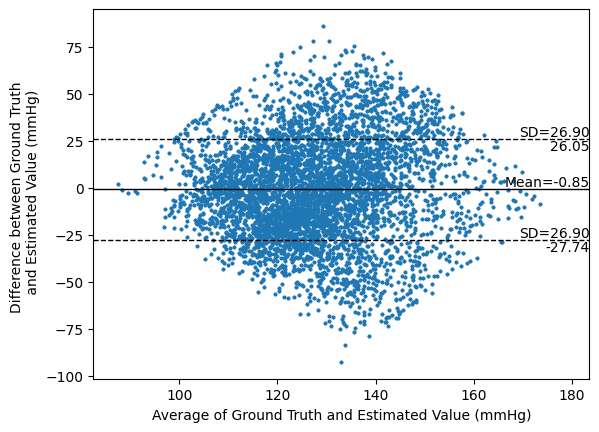

In [71]:
bland_altman_plot(out_max,gt_max)

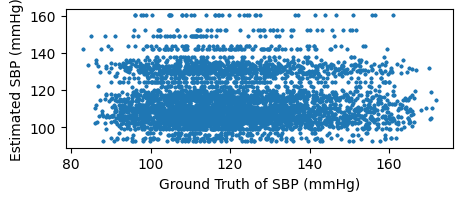

In [25]:
plt.figure(figsize=(5,1.8))
plt.ylabel("Estimated SBP (mmHg)")
plt.xlabel("Ground Truth of SBP (mmHg)")
plt.scatter(out_max,gt_max,s=3)
# plt.xlim(xmin,xmax)

In [132]:
train = np.load(r"../data\processed\BP_npy\0625_256_2_clean\p00\train.npy")[:,:,0]
# train = np.load(r"../data\processed\BP_npy\1127_256_balanced\p00\train.npy")[:,:,0]
train -= scales[0,0]
train /= scales[0,1]
tr_min,tr_max = calc_min_max(train)

In [73]:
SBP_hist_20 = np.array([ 83.05228424,  87.48763275,  91.92298126,  96.35832977,
        100.79367828, 105.22902679, 109.66437531, 114.09972382,
        118.53507233, 122.97042084, 127.40577698, 131.84112549,
        136.276474  , 140.71182251, 145.14717102, 149.58251953,
        154.01786804, 158.45321655, 162.88856506, 167.32391357,
        171.75926208])
DBP_hist_20 = np.array([ 50.06516266,  52.79799271,  55.53082275,  58.2636528 ,
         60.99648285,  63.72930908,  66.46214294,  69.19496918,
         71.92780304,  74.66062927,  77.39346313,  80.12628937,
         82.8591156 ,  85.59194946,  88.3247757 ,  91.05760956,
         93.79043579,  96.52326965,  99.25609589, 101.98892975,
        104.72175598])

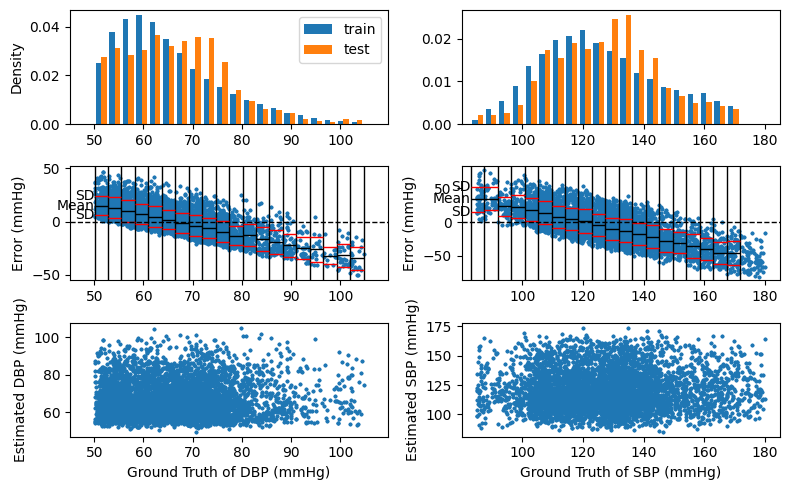

In [134]:
idx = []
mes = np.zeros(20)
sds = np.zeros(20)
for i in range(20):
    r = np.where((DBP_hist_20[i]<=gt_min)&(DBP_hist_20[i+1]>gt_min))[0]
    idx.append(r)
    mes[i] = np.mean(errors[0][r])
    sds[i] = np.std(errors[0][r])
plt.figure(figsize=(8,5))
plt.subplot(321)  
xmin = gt_min.min()-5
xmax = gt_min.max()+5
plt.hist([tr_min,gt_min],bins=DBP_hist_20,histtype='bar',label=["train","test"],density=True)
plt.xlim(xmin,xmax)
plt.ylabel("Density")
plt.legend()

plt.subplot(322)
xmin = gt_max.min()-5
xmax = gt_max.max()+5
plt.hist([tr_max,gt_max],bins=SBP_hist_20,histtype='bar',label=["train","test"],density=True)
plt.xlim(xmin,xmax)
plt.subplot(3,2,3)
xmin = gt_min.min()-5
xmax = gt_min.max()+5
ymin=errors[0].min()-5
ymax=errors[0].max()+5
plt.xlim(xmin,xmax)
plt.scatter(gt_min,errors[0],s=3)
plt.vlines(DBP_hist_20,ymin=ymin,ymax=ymax,colors="black",linewidth=1)
plt.ylim(ymin,ymax)
plt.hlines(mes,DBP_hist_20[:-1],DBP_hist_20[1:],colors='black',linewidth=1)
plt.hlines(mes+sds,DBP_hist_20[:-1],DBP_hist_20[1:],colors='red',linewidth=1)
plt.hlines(mes-sds,DBP_hist_20[:-1],DBP_hist_20[1:],colors='red',linewidth=1)
plt.hlines(0,xmin,xmax,colors='black',linestyles="dashed",linewidth=1)
plt.ylabel("Error (mmHg)")
plt.text(DBP_hist_20[0], mes[0], f"Mean",fontsize='medium', horizontalalignment = "right", verticalalignment ="center" ) 
plt.text(DBP_hist_20[0], mes[0]+sds[0], f"SD",fontsize='medium', horizontalalignment = "right", verticalalignment ="center" ) 
plt.text(DBP_hist_20[0], mes[0]-sds[0], f"SD",fontsize='medium', horizontalalignment = "right", verticalalignment ="center" ) 
plt.subplot(3,2,4)
xmin = gt_max.min()-5
xmax = gt_max.max()+5
for i in range(20):
    r = np.where((SBP_hist_20[i]<=gt_max)&(SBP_hist_20[i+1]>gt_max))[0]
    idx.append(r)
    mes[i] = np.mean(errors[1][r])
    sds[i] = np.std(errors[1][r])
ymin=errors[1].min()-5
ymax=errors[1].max()+5
plt.xlim(xmin,xmax)
plt.scatter(gt_max,errors[1],s=3)
plt.vlines(SBP_hist_20,ymin=ymin,ymax=ymax,colors="black",linewidth=1)
plt.ylim(ymin,ymax)
plt.hlines(mes,SBP_hist_20[:-1],SBP_hist_20[1:],colors='black',linewidth=1)
plt.hlines(mes+sds,SBP_hist_20[:-1],SBP_hist_20[1:],colors='red',linewidth=1)
plt.hlines(mes-sds,SBP_hist_20[:-1],SBP_hist_20[1:],colors='red',linewidth=1)
plt.hlines(0,xmin,xmax,colors='black',linestyles="dashed",linewidth=1)
plt.ylabel("Error (mmHg)")
plt.text(SBP_hist_20[0], mes[0], f"Mean",fontsize='medium', horizontalalignment = "right", verticalalignment ="center" ) 
plt.text(SBP_hist_20[0], mes[0]+sds[0], f"SD",fontsize='medium', horizontalalignment = "right", verticalalignment ="center" ) 
plt.text(SBP_hist_20[0], mes[0]-sds[0], f"SD",fontsize='medium', horizontalalignment = "right", verticalalignment ="center" ) 

plt.subplot(325)

xmin = gt_min.min()-5
xmax = gt_min.max()+5
plt.ylabel("Estimated DBP (mmHg)")
plt.xlabel("Ground Truth of DBP (mmHg)")
plt.scatter(gt_min,out_min,s=3)
plt.xlim(xmin,xmax)

plt.subplot(326)
xmin = gt_max.min()-5
xmax = gt_max.max()+5
plt.ylabel("Estimated SBP (mmHg)")
plt.xlabel("Ground Truth of SBP (mmHg)")
plt.scatter(gt_max,out_max,s=3)
plt.xlim(xmin,xmax)
plt.tight_layout()